In [1]:
#Simple nu-O event generator for 10s-of-MeV neutrinos
#Follows approach taken by NEWTON
#
#Steps:
# Supply total xs (different choices), interpolate
# Supply partial xs, fit coefficients, interpolate
# Specify neutrino flux, fold with xs, sample
# Choose excitation level based on exclusive cross sections
# My approach:
#   - Estimate lepton energy, sample lepton angle from Haxton MuDAR distribution
# NEWTON approach:
#   - Sample lepton angle from distributions on Enu vs. lepton angle from Haxton after applying unweighting
# Calculate lepton energy direction, nuclear recoil
# Draw from pre-computed TALYS de-excitation files to generate events
# Write output in ascii format
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
import dataLoaderUtils
import utils
import sys
import awkward_pandas

##################
##RUN PARAMETERS##
##################
output_name = "test"
outputFormat = "ascii" #'root', 'ascii'
nps = 10000

angle_sampling_type = "NEWTON" #'MuDAR' uses haxton angle plot for muDAR source, 
                              #'NEWTON' uses default NEWTON angle sampling

#############################
##NEUTRINO SOURCE PARAMTERS##
#############################
neutrinoSource = "MuDAR" #only 'MuDAR' currently.
neutrino_direction = [0,0,1]

################
##DEFINE GRIDS##
################
#Define energy grid
interpolationStep_MeV = 0.01 #Interpolate digitized xs plots with this precision
maxEnergy_MeV = 53
energies_MeV_interp = np.arange(0,maxEnergy_MeV,interpolationStep_MeV)
#Define angle grid
interpolationStep_deg = 1.
maxAngle_deg = 180. 
angles_deg_interp = np.arange(0,maxAngle_deg,interpolationStep_deg) #Note keeping 180 may cause issues

##########################
##SPECIFY DATA LOCATIONS##
##########################
#Inclusive xs, CSV of format Energy point [MeV], cross section [cm2]
#First point should always be 15.4,0.0 for proper interpolations
total_xs_fname = "data/total_xs/Haxton1987_NEWTON.csv"

#Exclusive cross sections from the Nakazato paper. Format is
#Threshold [MeV], J, parity[1=-,0=+], xs@20 MeV [cm2], xs@40 MeV [cm2], xs@60 MeV [cm2]
partial_xs_fname = "data/partial_xs/Nakazato2018.csv"

#Lepton angular distribution. Of format
#Energy [MeV], xs@15 deg. [cm2], Energy [MeV], xs@30 deg., ..., xs@165 deg [cm2]
MuDAR_lepton_angle_fname = "data/lepton_angle/Haxton1987_muDAR.csv"
SN_lepton_angle_fname = ""

newton_lepton_angle_folder = "data/lepton_angle_NEWTON/"
#Ensure folder name has proper format
if not newton_lepton_angle_folder.endswith("/"):
    newton_lepton_angle_folder+="/"

#From NucDeEx
#Filenames of format: Ex_00.250_ldmodel2_parity1.root
deexcitation_folder = "data/nucdeex/"
#Ensure folder name has proper format
if not deexcitation_folder.endswith("/"):
    deexcitation_folder+="/"

#################
##Plot settings##
#################
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14


In [2]:
#######################
##Calculate threshold##
#######################
#(160 + 8 electrons) + nu_e -> (16F + 8 electrons) + 1 electron 
threshold = (utils.atomic_mass_16F_amu-utils.atomic_mass_16O_amu)*utils.amu_to_MeV
print(f"Threshold of 16O CC process is {threshold:.3f} MeV")

Threshold of 16O CC process is 15.412 MeV


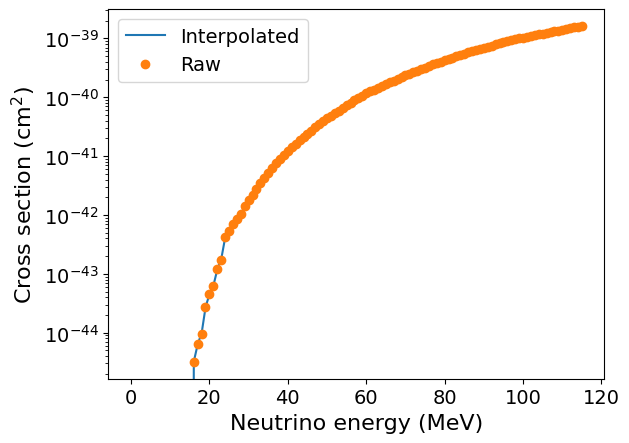

In [3]:
#################
##Load total XS##
#################
energies_MeV_raw,xs_cm2_raw = dataLoaderUtils.loadCrossSectionCSV(total_xs_fname,threshold==threshold)

#Log-linear inteerpolation
with np.errstate(divide='ignore', invalid='ignore'):
    logxs_cm2_raw = np.log10(xs_cm2_raw)
logxs_interp = np.interp(energies_MeV_interp, energies_MeV_raw, logxs_cm2_raw,left=-np.inf, right=logxs_cm2_raw[-1])
xs_cm2_interp = np.power(10,logxs_interp)

########
##Plot##
########
plt.plot(energies_MeV_interp,xs_cm2_interp,label="Interpolated")
plt.plot(energies_MeV_raw,xs_cm2_raw,ls="",marker="o",label="Raw")
plt.legend()
plt.xlabel("Neutrino energy (MeV)")
plt.ylabel("Cross section (cm$^2$)")
plt.yscale("log")


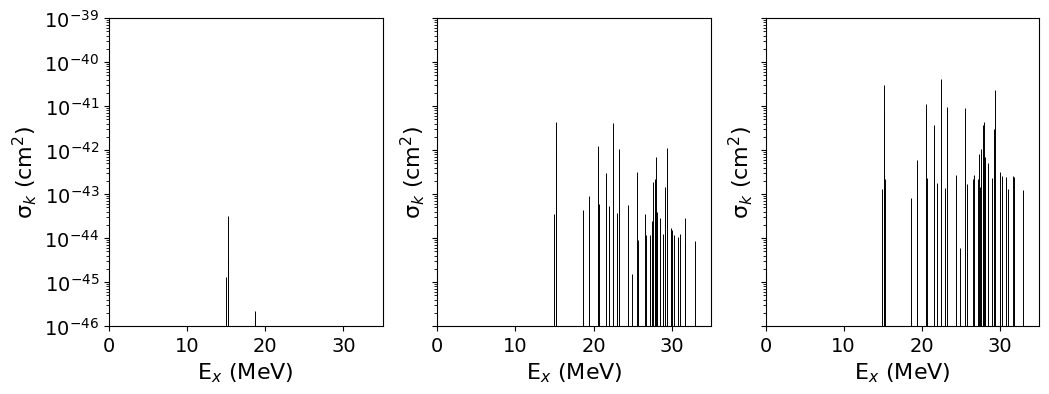

,Excited level [MeV],J,Parity,xs@20 MeV [cm2],xs@40 MeV [cm2],xs@60 MeV [cm2]
0,14.91,0,-,1.28e-45,3.54e-44,1.32e-43
1,15.16,1,-,3.10e-45,9.96e-43,6.81e-42
2,15.21,2,-,3.16e-44,4.38e-42,3.05e-41
3,15.25,3,-,0.00e+00,3.80e-45,2.25e-43
4,18.67,1,+,2.15e-46,4.37e-44,8.03e-44
5,19.42,2,-,0.00e+00,9.18e-44,5.82e-43
6,19.43,1,+,0.00e+00,3.22e-44,8.65e-44
7,20.57,1,-,0.00e+00,1.22e-42,1.09e-41
8,20.69,1,+,0.00e+00,5.99e-44,2.35e-43
9,21.62,2,-,0.00e+00,3.04e-43,3.70e-42


In [4]:
#################################
##LOAD EXCLUSIVE CROSS SECTIONS##
#################################
excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,xs20,xs40,xs60 = dataLoaderUtils.loadNazakatoPartialXSData(partial_xs_fname,xs_threshold=1e-46)

########
##Plot##
########
#Make 3 plots of xs vs. excitation energy 
fig,ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

#Keep only non-zero cross sections for plot
mask = xs20 > 0
ax[0].vlines(excitedLevels_MeV[mask], 1e-46, xs20[mask],color="k",lw=0.7)
mask = xs40 > 0
ax[1].vlines(excitedLevels_MeV[mask], 1e-46, xs40[mask],color="k",lw=0.7)
mask = xs60 > 0
ax[2].vlines(excitedLevels_MeV[mask], 1e-46, xs60[mask],color="k",lw=0.7)

plt.yscale("log")
ax[0].set_xlim(0,35)
ax[0].set_xlabel("E$_x$ (MeV)")
ax[0].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[0].set_ylim(1e-46,1e-39)

ax[1].set_xlim(0,35)
ax[1].set_xlabel("E$_x$ (MeV)")
ax[1].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[1].set_ylim(1e-46,1e-39)

ax[2].set_xlim(0,35)
ax[2].set_xlabel("E$_x$ (MeV)")
ax[2].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[2].set_ylim(1e-46,1e-39)
plt.show()


df = pd.DataFrame({
    "Excited level [MeV]": excitedLevels_MeV,
    "J": excitedLevels_J,
    "Parity": excitedLevels_parity,
    "xs@20 MeV [cm2]": xs20,
    "xs@40 MeV [cm2]": xs40,
    "xs@60 MeV [cm2]": xs60,
})

# Create the Styler object
formatted_df = df.style.format({
    "Excited level [MeV]": "{:.2f}",
    "J": "{}",
    "Parity": "{}",
    "xs@20 MeV [cm2]": "{:.2e}",
    "xs@40 MeV [cm2]": "{:.2e}",
    "xs@60 MeV [cm2]": "{:.2e}"
}).set_properties(**{
    'text-align': 'center'
})

#Center the column headers
formatted_df.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')])
])

# Display the styled DataFrame
formatted_df

In [5]:
###############################
##SOLVE NAKAZATO COEFFICIENTS##
###############################
c1s,c2s,c3s = utils.solveNakazatoCoeffs(excitedLevels_MeV,xs20,xs40,xs60)

########
##Plot##
########
df = pd.DataFrame({
    "Excited level [MeV]": excitedLevels_MeV,
    "a": c1s,
    "b": c2s,
    "c": c3s,
})

# Create the Styler object
formatted_df = df.style.format({
    "Excited level [MeV]": "{:.2f}",
    "a": "{:.4f}",
    "b": "{:.4f}",
    "c": "{:.4f}"
}).set_properties(**{
    'text-align': 'center'
})

# Center the column headers
formatted_df.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')])
])

formatted_df
      


,Excited level [MeV],a,b,c
0,14.91,-42.5674,3.6692,1.0302
1,15.16,-40.7141,5.0034,0.6298
2,15.21,-40.0334,5.3599,1.5232
3,15.25,-41.7075,10.0983,0.0000
4,18.67,-42.9389,0.9266,-0.6685
5,19.42,-41.6232,3.7082,0.0000
6,19.43,-42.7354,1.9831,0.0000
7,20.57,-40.1971,4.1432,0.0000
8,20.69,-42.1488,2.5700,0.0000
9,21.62,-40.5244,4.4735,0.0000


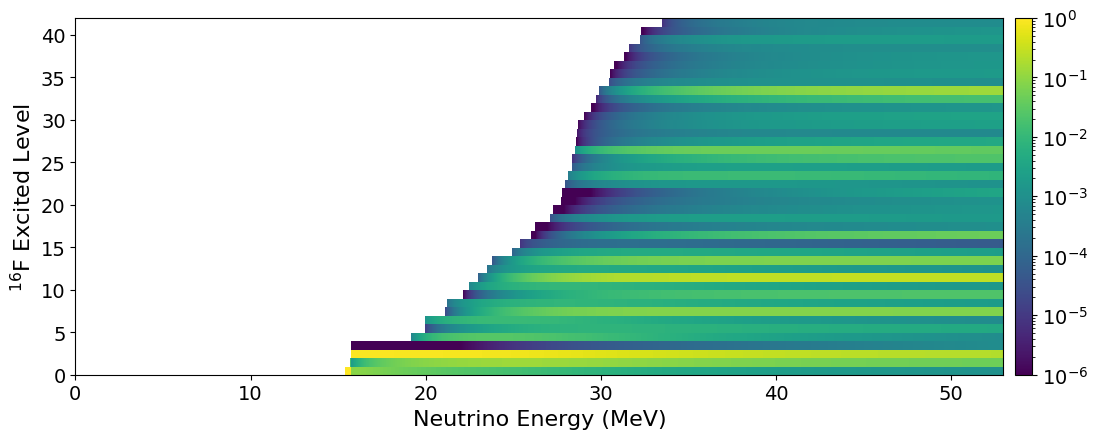

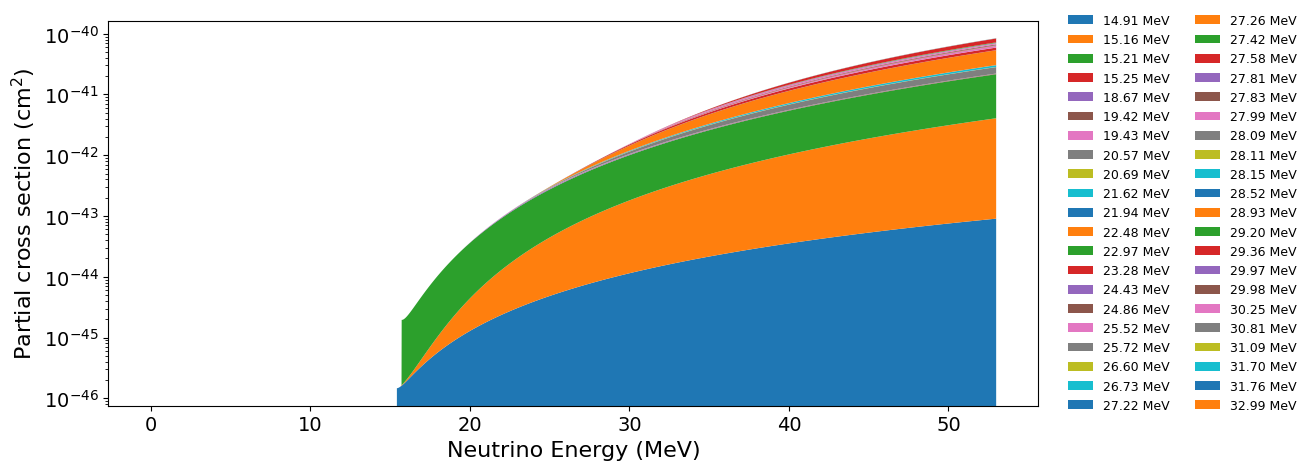

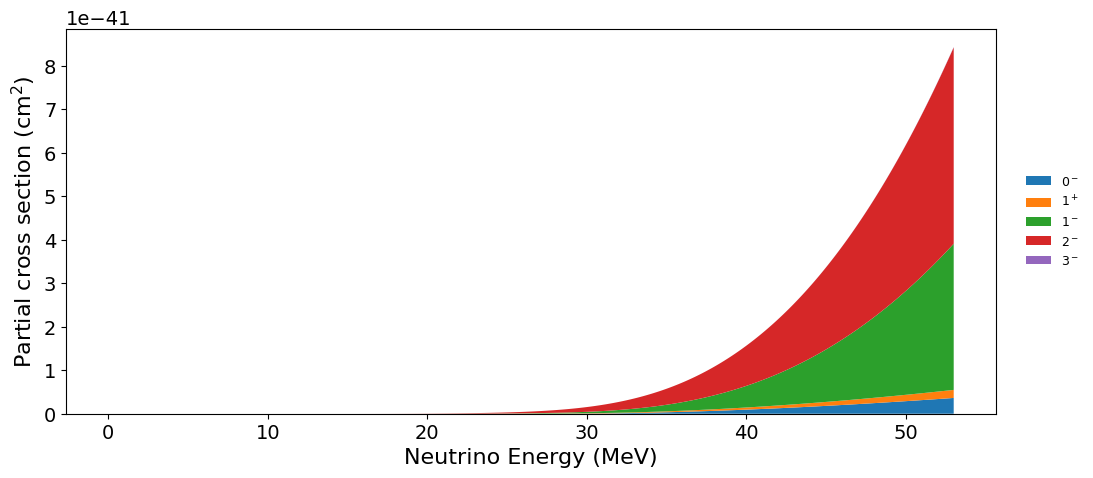

In [6]:
#########################################################
##CALCULATE PARTIAL CROSS SECTIONS OVER OUR ENERGY GRID##
#########################################################
partial_xs = utils.calcNakazatoPartialXS(excitedLevels_MeV,energies_MeV_interp,c1s,c2s,c3s)

#################################################
##NORMALIZE PARTIAL CROSS SECTIONS FOR SAMPLING##
#################################################
Z = np.vstack([np.asarray(xs) for xs in partial_xs])
#Convert to probabilities
colsum = Z.sum(axis=0)                                
excitation_probs = np.zeros_like(Z, dtype=float)
nonzero_mask = colsum > 0
excitation_probs[:, nonzero_mask] = Z[:, nonzero_mask] / colsum[nonzero_mask]

########
##Plot##
########
# Plot: y-axis is uniform "level index" bins; labels show actual excited levels (optional)
fig, ax = plt.subplots(figsize=(12, 4.5))

im = ax.imshow(
    excitation_probs,
    origin="lower",
    aspect="auto",
    interpolation="nearest",
    norm=LogNorm(vmin=1e-6, vmax=1.0),
    extent=[energies_MeV_interp[0],
            energies_MeV_interp[-1],
            0,
            excitation_probs.shape[0]]
)

ax.set_xlabel("Neutrino Energy (MeV)")
ax.set_ylabel("$^{16}$F Excited Level")
cbar = plt.colorbar(im, ax=ax, pad=0.01)
plt.tight_layout()

#####################
##Plot exclusive xs##
#####################
fig2,ax2 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in partial_xs])   # (nlev, nE)

labels = [f"{excitedLevels_MeV[i]:.2f} MeV" for i in range(xs_stack.shape[0])]

ax2.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax2.set_xlabel("Neutrino Energy (MeV)")
ax2.set_ylabel(r"Partial cross section (cm$^2$)")
ax2.set_yscale("log")

ax2.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    ncol=2,                      # number of columns (adjust as needed)
    fontsize=9,
    frameon=False
)

##################
##Multipole plot##
##################
JPis = np.array([f"{J}$^{p}$"
                 for J, p in zip(excitedLevels_J, excitedLevels_parity)])
multipoles = np.unique(JPis)
multipole_xs=[np.zeros_like(energies_MeV_interp) for _ in multipoles]
for mi, multipole in enumerate(multipoles):
    indices = np.where(JPis == multipole)[0]
    for idx in indices:
        multipole_xs[mi] += partial_xs[idx]    # <-- add into the right bucket


fig3,ax3 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in multipole_xs])   # (nMultipoles, nE)
labels = list(multipoles)

ax3.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax3.set_xlabel("Neutrino Energy (MeV)")
ax3.set_ylabel(f"Partial cross section (cm$^2$)")
ax3.set_yscale("linear")

ax3.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    fontsize=9,
    frameon=False
)

plt.show()

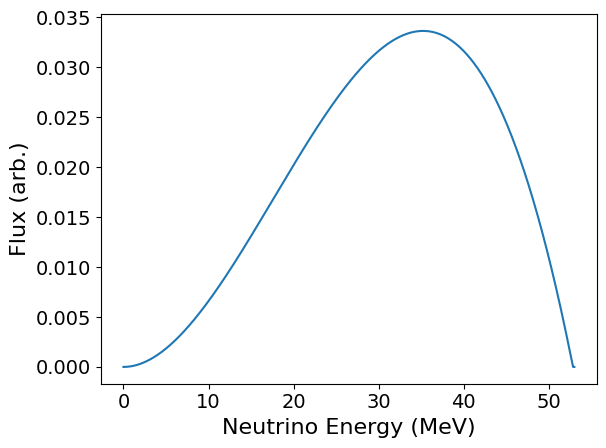

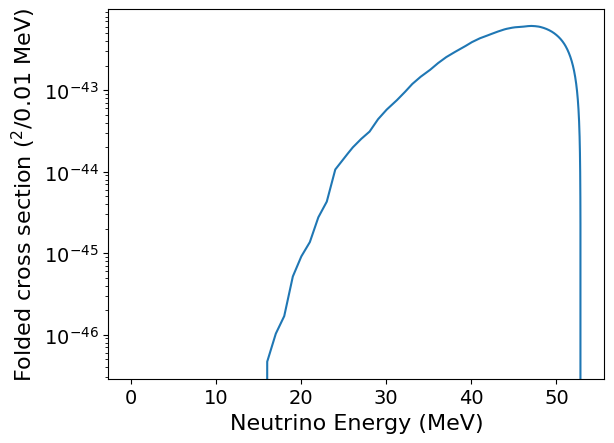

8.256963225502652e-42


In [7]:
###############################
##CALCULATE NEUTRINO SPECTRUM##
###############################
dar_spectrum = 96*np.power(energies_MeV_interp,2) * np.power(utils.mass_mu_MeV,-4)  * (utils.mass_mu_MeV - 2*energies_MeV_interp)
dar_spectrum = np.where(dar_spectrum > 0, dar_spectrum, 0) #Function turns negative at high energies, replace with zeros

#TODO: Supernova spectrum

if neutrinoSource=="MuDAR":
  spectrum = dar_spectrum
else:
  spectrum = ""

##########################################################
##CALCULATE FOLDED SPECTRUM, FLUX-AVERAGED CROSS SECTION##
##########################################################
folded_spectrum = np.multiply(xs_cm2_interp,spectrum)
neutrino_energy_probs = folded_spectrum / folded_spectrum.sum()

#Calculate flux-averaged spectrum
num = np.trapezoid(xs_cm2_interp * dar_spectrum, energies_MeV_interp)
den = np.trapezoid(dar_spectrum, energies_MeV_interp)
flux_averaged_xs = num / den
flux_averaged_xs_naturalunits = flux_averaged_xs/utils.hbar_c_squared

########
##PLOT##
########
fig,ax=plt.subplots()
plt.plot(energies_MeV_interp,dar_spectrum)
ax.set_xlabel("Neutrino Energy (MeV)")
ax.set_ylabel(f"Flux (arb.)")

fig2,ax2=plt.subplots()
plt.plot(energies_MeV_interp,folded_spectrum)
plt.yscale("log")
ax2.set_xlabel("Neutrino Energy (MeV)")
ax2.set_ylabel(f"Folded cross section ($^2$/{interpolationStep_MeV} MeV)")


plt.show()
print(flux_averaged_xs)

In [8]:
################################################
##LOAD LEPTON ANGLE DISTRIBUTIONS, INTERPOLATE##
################################################
if angle_sampling_type=="MuDAR":
  lepton_angles_raw,lepton_energies_raw,lepton_angle_xs_raw = dataLoaderUtils.loadHaxtonMuDARAngles(MuDAR_lepton_angle_fname)
  #Intepolate the above plot over our energy/angle grid
  angle_vs_lepton_energy_vs_xs_cm2 = utils.interpolateHaxtonMuDARAngles(lepton_angles_raw,angles_deg_interp,lepton_energies_raw,energies_MeV_interp,lepton_angle_xs_raw)

  #Modify angular distribution based on solid angle subtended by each theta
  theta_rad_interp = np.deg2rad(angles_deg_interp)
  sin_weights = np.sin(theta_rad_interp)
  weighted_xs = angle_vs_lepton_energy_vs_xs_cm2 * sin_weights[:, np.newaxis]

  #Create probabilitiy distributions, normalized per lepton energy
  lepton_angle_probs = np.zeros_like(weighted_xs)
  colsum = weighted_xs.sum(axis=0)
  mask = colsum > 0
  lepton_angle_probs[:, mask] = weighted_xs[:, mask] / colsum[mask]

#######################################################
##LOAD NEWTON LEPTON ANGLE DISTRIBUTIONS, INTERPOLATE##
#######################################################
else:
  angles_deg_raw, Enus_NEWTON_raw, Enus_vs_angle_raw = dataLoaderUtils.loadNewtonDoubleDiffData(newton_lepton_angle_folder)
  lepton_angle_probs = []
  Enus_vs_lepton_angles_vs_xs_cm2 = []
  for iEx,Enu_energy_dist_raw in enumerate(Enus_NEWTON_raw):
    pdf,unnormalized_pdf = utils.interpolateNEWTONAnglesAndNormalize(
                                                              angles_deg_raw,
                                                              angles_deg_interp,
                                                              Enus_NEWTON_raw[iEx],
                                                              energies_MeV_interp,
                                                              Enus_vs_angle_raw[iEx]
                                                              )
    Enus_vs_lepton_angles_vs_xs_cm2.append(unnormalized_pdf)
    
  weighted_xs = utils.checkNewtonAnglesPlot(Enus_vs_lepton_angles_vs_xs_cm2,folded_spectrum,excitedLevels_MeV-14.91,energies_MeV_interp)

  lepton_angle_probs = np.zeros_like(weighted_xs)
  colsum = weighted_xs.sum(axis=0)
  mask = colsum > 0
  lepton_angle_probs[:, mask] = weighted_xs[:, mask] / colsum[mask]


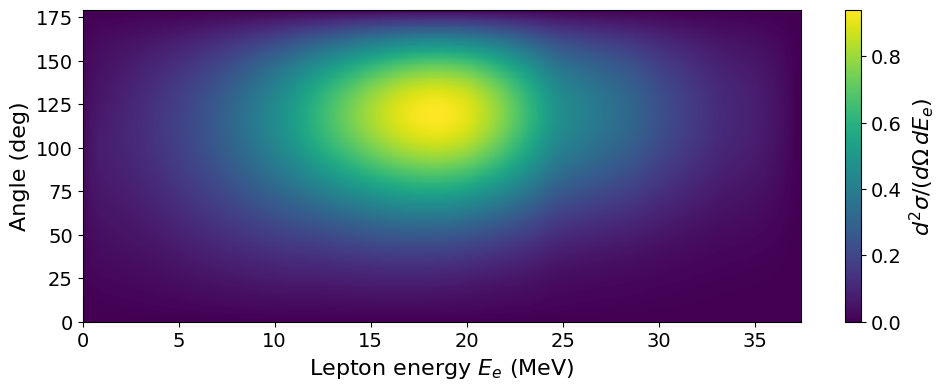

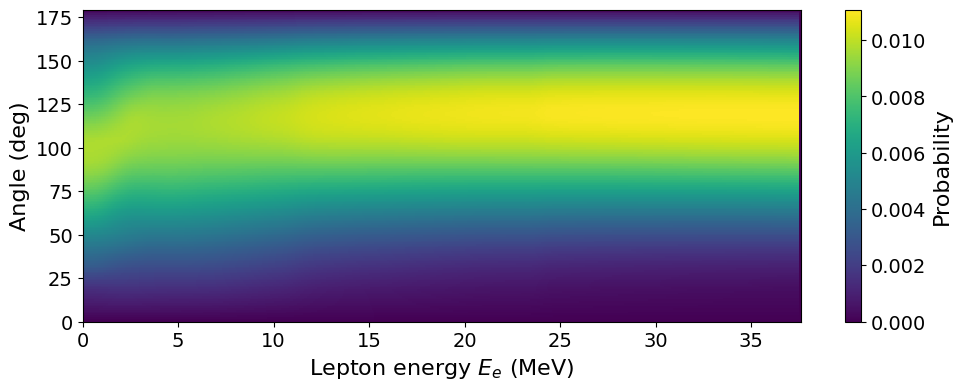

/var/folders/n0/5khn9c9d03746p9xsp8y4btm0000gn/T/ipykernel_8256/4267270017.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


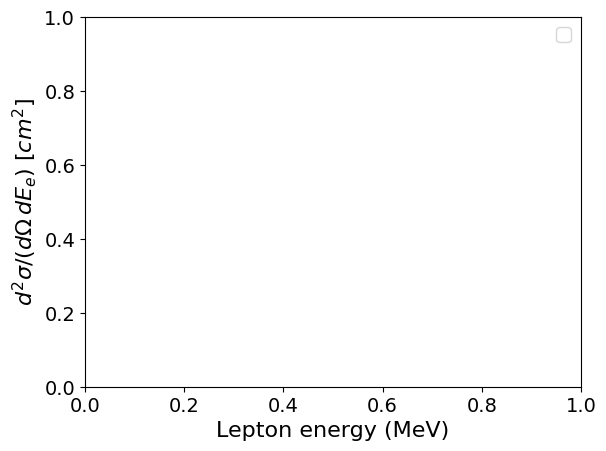

In [ ]:

########
##Plot##
########
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(
    weighted_xs,
    origin="lower",
    aspect="auto",
    extent=[energies_MeV_interp[0], energies_MeV_interp[-1],
            angles_deg_interp[0], angles_deg_interp[-1]],
    interpolation="None"
)
ax.set_xlabel("Lepton energy $E_e$ (MeV)")
ax.set_ylabel("Angle (deg)")
cb = fig.colorbar(im, ax=ax)
cb.set_label(f"$d^2\sigma/(d\Omega\, dE_e)$")
ax.set_xlim(0,52.8-threshold)
fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=(10,4))
im2 = ax2.imshow(
    lepton_angle_probs,
    origin="lower",
    aspect="auto",
    extent=[energies_MeV_interp[0], energies_MeV_interp[-1],
            angles_deg_interp[0], angles_deg_interp[-1]],
    interpolation="None"
)
ax2.set_xlabel("Lepton energy $E_e$ (MeV)")
ax2.set_ylabel("Angle (deg)")
cb2 = fig2.colorbar(im2, ax=ax2)
cb2.set_label("Probability")
fig2.tight_layout()
ax2.set_xlim(0,53-threshold)
plt.show()

if angle_sampling_type=="MuDAR":
  #Plot 1D curves
  fig3,ax3=plt.subplots()
  for angle in lepton_angles_raw:
      #Find index of angle in angles_deg_interp
      idx = np.searchsorted(angles_deg_interp, angle)
      #Plot 1D curve
      ax3.plot(energies_MeV_interp, angle_vs_lepton_energy_vs_xs_cm2[idx, :], label=f"{angle}°")
  ax3.set_ybound(0,10e-44)
  ax3.set_xbound(0,55)
  plt.xlabel("Lepton energy (MeV)")
  plt.ylabel(f"$d^2\sigma/(d\Omega\, dE_e)$ [$cm^2$]")
  plt.legend()
  plt.show()
else:
  fig3,ax3=plt.subplots()
  for angle in [15,30,45,60,75,90,105,120,135,150,165]:
    # Find the closest index in your interpolated grid
    idx = np.abs(angles_deg_interp - angle).argmin()
    # Plot the summed rate for that angle
    ax3.plot(energies_MeV_interp, weighted_xs[idx, :], label=f"{angles_deg_interp[idx]:.0f}")
  ax3.set_ybound(0,10e-44)
  ax3.set_xbound(0,55)
  plt.xlabel("Lepton energy (MeV)")
  plt.ylabel(f"$d^2\sigma/(d\Omega\, dE_e)$ [$cm^2$]")
  plt.legend()
  plt.show()

In [10]:
#Load de-excitation data
ex_dfs = utils.loadNucDeExData(deexcitation_folder)

In [11]:
#Generate our events in MARLEY format
line=str(flux_averaged_xs_naturalunits)

#Number of initial particles, hardcoded
Ni = 2 #Hardcoded

#Sample neutrino eneries from folded xs times spectrum
sampled_neutrino_energies_MeV = np.random.choice(energies_MeV_interp, size=nps, p=neutrino_energy_probs)

outFile = open("test.o","w")
outFile.write(line)

#For validation
sampled_lepton_energies = []
calculated_lepton_energies = []
sampled_thetas_deg = []

items = [energies_MeV_interp,excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitation_probs,ex_dfs,
        angles_deg_interp,lepton_angle_probs,
        neutrino_direction,utils.nuc_mass_16O_MeV,utils.nuc_mass_16F_MeV,
        "16O","16F","ve","electron"]
args = [(Enu, *items) for Enu in sampled_neutrino_energies_MeV]

############
#MAIN LOOP##
############
#Sample our excitation probabilities at the neutrino energy, calculate lepton energy, angle
for inps,Enu in enumerate(sampled_neutrino_energies_MeV):
  if inps%5000==0:
     print(f"On entry {inps}")

  header,inParticles,outParticles = utils.sampleEvent(args[inps])
  for part in outParticles:
     if part["pdg"]==11:
        calculated_lepton_energies.append(part["totalE"]-part["mass"])
  sampled_lepton_energies.append(header["Ee_sampled"])
  sampled_thetas_deg.append(header["theta_deg"])

#Write ascii output 
outFile.close()



On entry 0
On entry 5000


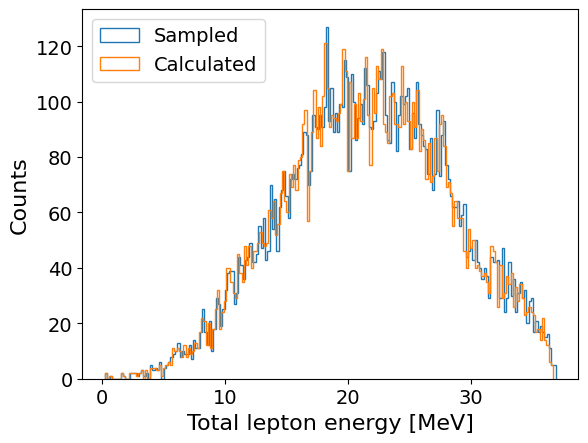

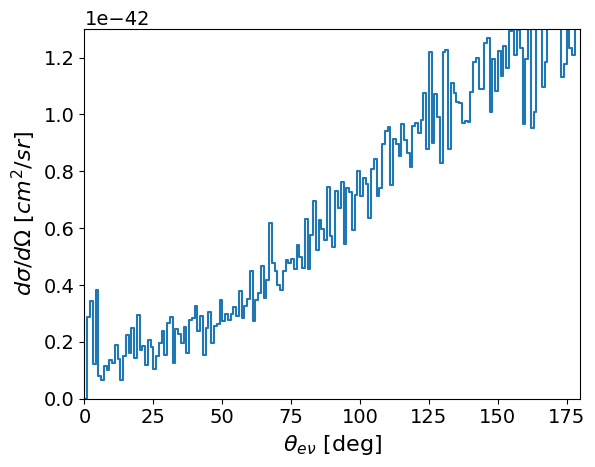

In [12]:
#Validation
fig,ax = plt.subplots()
plt.hist(sampled_lepton_energies,bins=200,histtype='step',label="Sampled")
plt.hist(calculated_lepton_energies,bins=200,histtype='step',label="Calculated")
plt.xlabel("Total lepton energy [MeV]")
plt.ylabel("Counts")
plt.legend()


fig2,ax2 = plt.subplots()
counts, edges = np.histogram(sampled_thetas_deg, bins=180, range=(0, 180))
bin_widths = np.diff(edges) 
centers = 0.5 * (edges[:-1] + edges[1:])

normed_counts = counts / np.sum(counts)
dsigma_dtheta = (normed_counts * flux_averaged_xs / bin_widths)

centers_rad = np.deg2rad(centers)
dsigma_dOmega = (dsigma_dtheta * (180/np.pi)) / (2 * np.pi * np.sin(centers_rad))

plt.step(centers, dsigma_dOmega, where='mid')
plt.xlabel(r"$\theta_{e\nu}$ [deg]")
plt.ylabel(r"$d\sigma/d\Omega$ [$cm^2/sr$]") # Explicitly label as per degree
plt.ylim(0,13e-43)
plt.xlim(0,180)
plt.show()
